In [1]:
from google.colab import drive
drive.mount('/content/drive')
ROOT_PATH = '/content/drive/MyDrive/Colab Notebooks/DataMining/'

Mounted at /content/drive


In [2]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 569 kB 9.4 MB/s 


In [3]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_selection import RFE

import lightgbm as lgb
import shap

import warnings
warnings.filterwarnings("ignore")

In [4]:
data=pd.read_csv(ROOT_PATH + 'bank.csv')
data.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,2476,yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,184,no,no,unknown,5,may,673,2,-1,0,unknown,yes


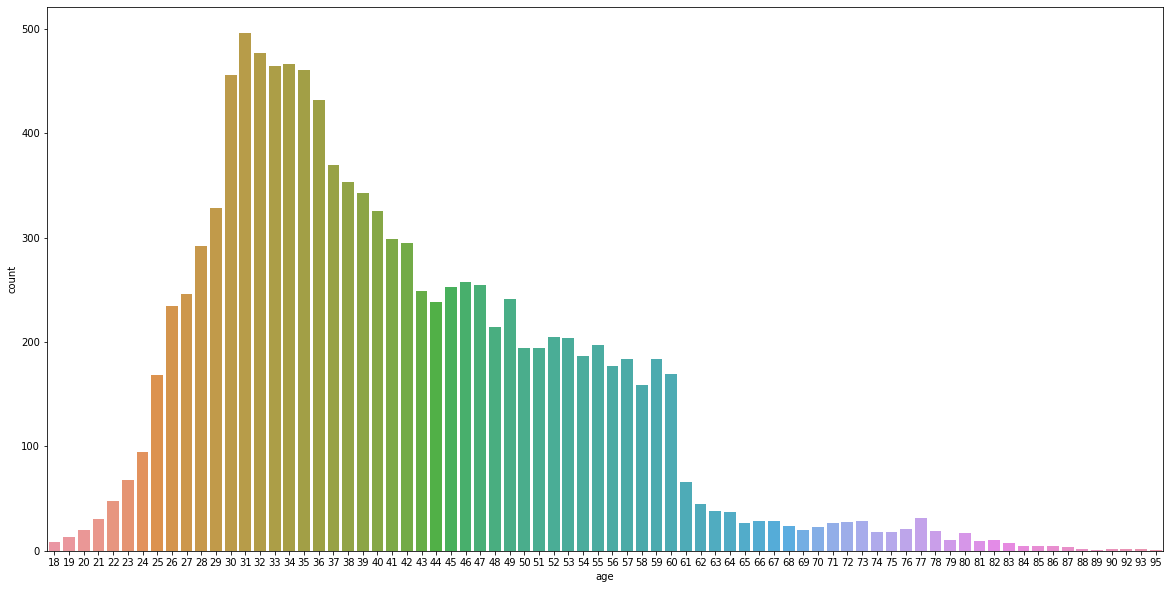

In [5]:
plt.figure(figsize=(20,10))
sns.countplot(data['age'])
plt.show()

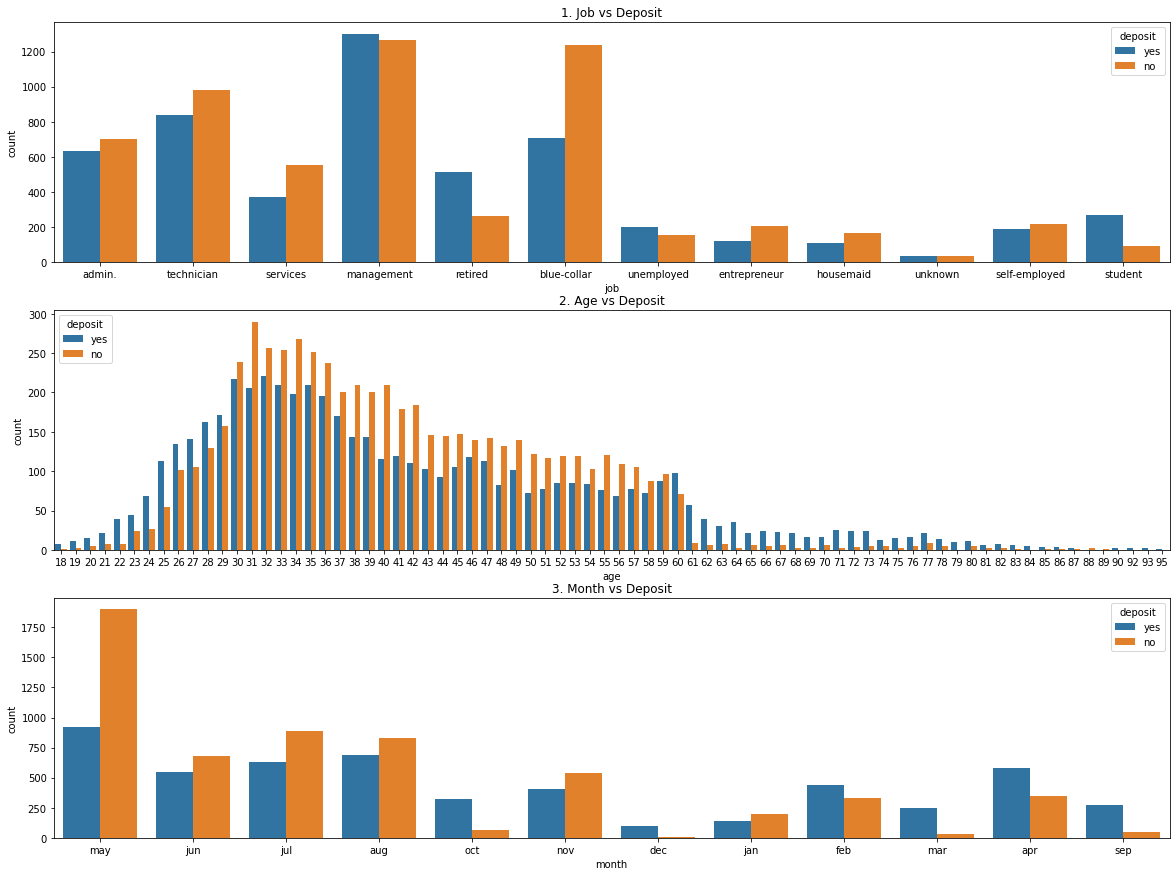

In [6]:
plt.figure(figsize=(20,15))
plt.subplot(3,1,1)
sns.countplot(data['job'],hue=data['deposit'])
plt.title('1. Job vs Deposit')

plt.subplot(3,1,2)
sns.countplot(data['age'],hue=data['deposit'])
plt.title('2. Age vs Deposit')

plt.subplot(3,1,3)
sns.countplot(data['month'],hue=data['deposit'])
plt.title('3. Month vs Deposit')
plt.show()

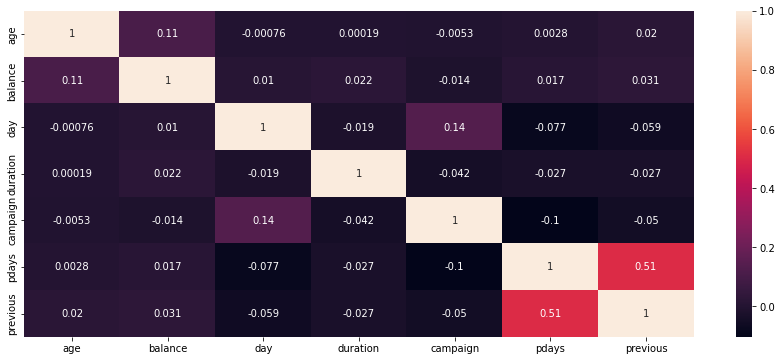

In [7]:
plt.figure(figsize=(15,6))
sns.heatmap(data.corr(),annot=True)
plt.show()

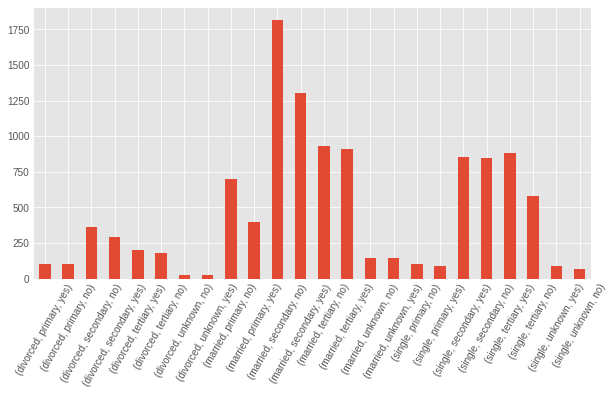

In [8]:
style.use('seaborn-darkgrid') 
style.use('ggplot')
data.groupby(['marital','education'])['deposit'].value_counts().plot(kind='bar',figsize=(10,5))
plt.xticks(rotation='60')
plt.xlabel(None)
plt.show()

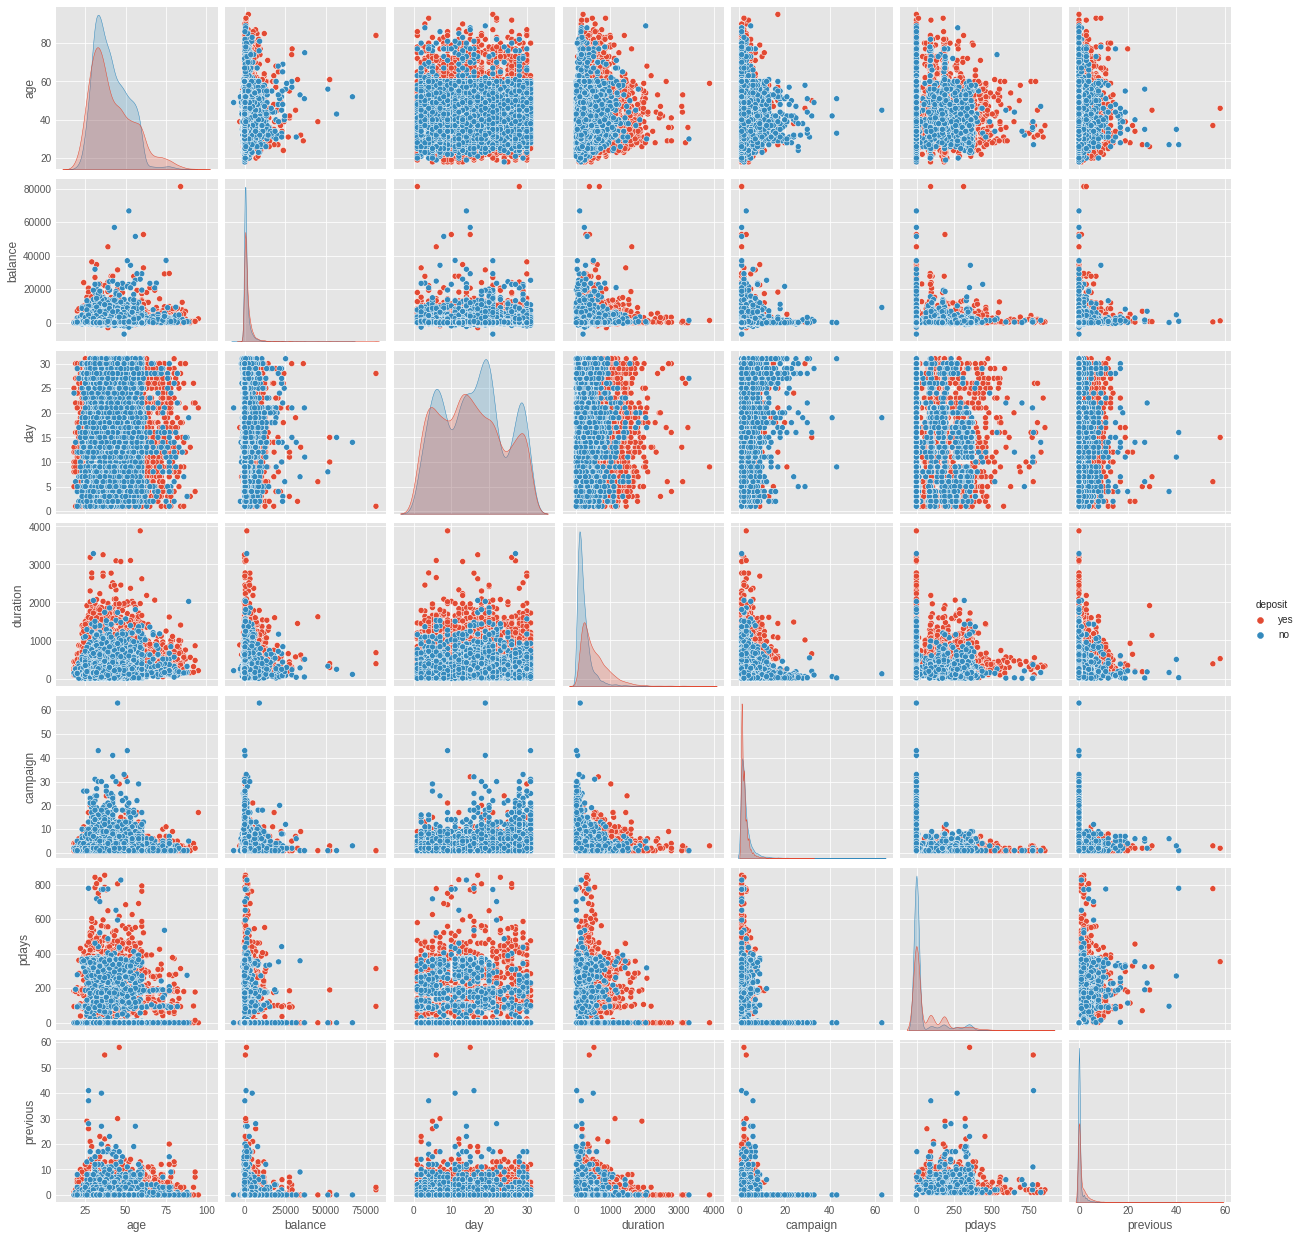

In [9]:
sns.pairplot(data=data,hue='deposit')
plt.show()

In [10]:

le = LabelEncoder()
le_count = 0

for col in data:
    if data[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(data[col].unique())) <= 2:
        
            le.fit(data[col])
            data[col] = le.transform(data[col])
            
           
            le_count += 1
            print('%d columns were label encoded.' % le_count)

1 columns were label encoded.
2 columns were label encoded.
3 columns were label encoded.
4 columns were label encoded.


In [11]:
data1=pd.get_dummies(data)

In [12]:
data1.head(2)

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,59,0,2343,1,0,5,1042,1,-1,0,...,0,0,1,0,0,0,0,0,0,1
1,56,0,45,0,0,5,1467,1,-1,0,...,0,0,1,0,0,0,0,0,0,1


## Split for training data and testing data

In [13]:
X=data1.drop(columns='deposit',axis=1)
y=data1.deposit

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 11)

## Light GBM model

In [15]:
model = lgb.LGBMClassifier(learning_rate= 0.01,n_estimators=1000)
model.fit(X_train,y_train)

LGBMClassifier(learning_rate=0.01, n_estimators=1000)

In [16]:
y_pred= model.predict(X_test)

[[976 195]
 [118 944]]
0.8598298253470668


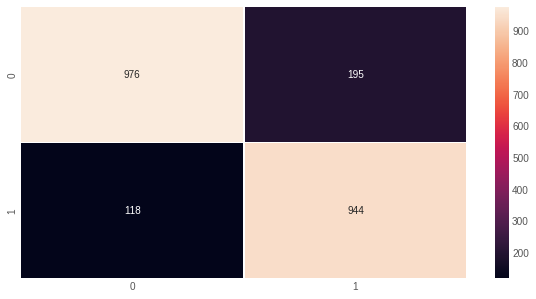

In [17]:
cm = confusion_matrix(y_test, y_pred)
print(cm)
print(accuracy_score(y_test, y_pred))
plt.figure(figsize=(10,5))
sns.heatmap(cm, annot=True, fmt="d", linewidths=.5)
plt.show()

## Checking overfitting¶

In [18]:
print('Training set score: {:.4f}'.format(model.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(model.score(X_test, y_test)))

Training set score: 0.9092
Test set score: 0.8598


## Shap

The model trained well, and we got 0.86 scores on the test set, which is not bad. Here the main question is which features are significant and how much each component affects the model, and how? Sklearn feature importance and permutation importance can give us the value for the feature importance.

This time, I'll use the shap library to analyze the model result. For a given prediction, SHAP values can tell us how much each factor in a model has contributed to the forecast. We can also aggregate SHAP values to understand how the model generally makes predictions. Ultimately, we can use SHAP values to identify and visualize important relationships in our model. In doing so, we gain an understanding of how our model works.

100%|===================| 2230/2233 [01:13<00:00]       

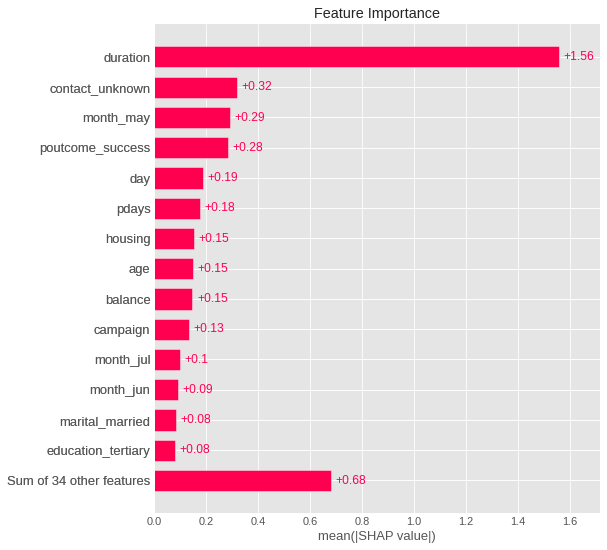

In [19]:
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test)
plt.title('Feature Importance')
shap.plots.bar(shap_values,max_display=15)

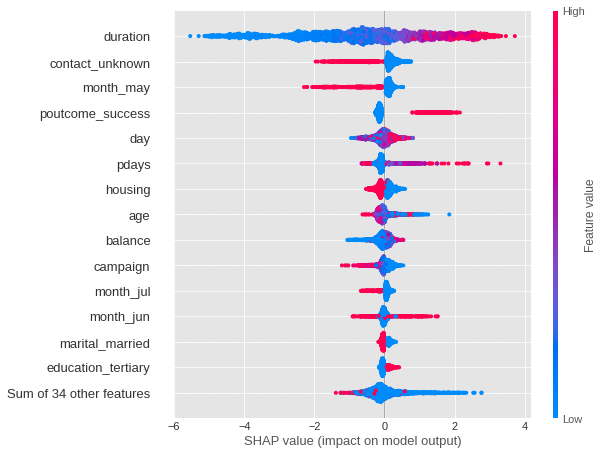

In [20]:
shap.plots.beeswarm(shap_values, max_display=15)

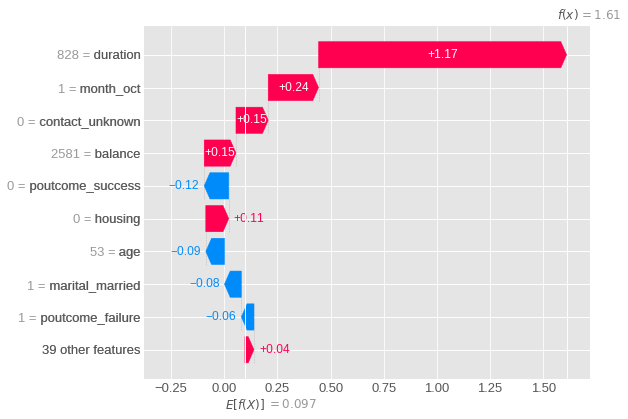

In [21]:
shap.plots.waterfall(shap_values[0],max_display=10)

## Interraption
- Duration time directly affects the customer's decision.
- In may, the effectiveness of the campaign decreased. When we are looking at the beeswarm graph, more month_may value reduced shap values which affect get a failure on it
- Focusing on previous success campaign, customers return as a positive result.
- The campaign should focus on the customers who had an appropriate balance amount rather than concentrate on everyone

100%|===================| 2222/2233 [01:12<00:00]       

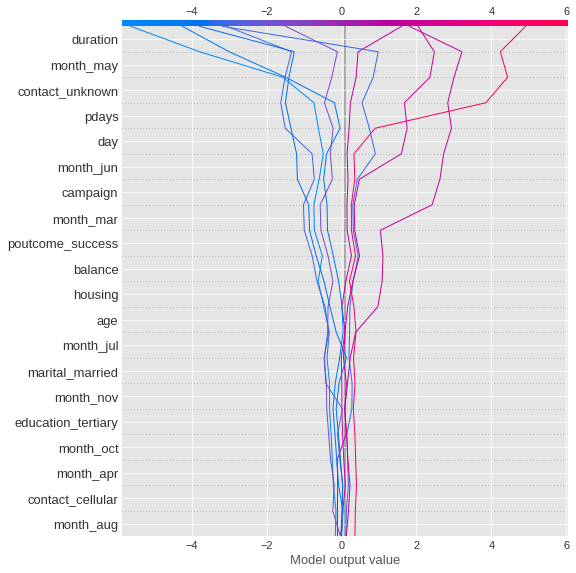

In [22]:
expected_value = explainer.expected_value
shap_array = explainer.shap_values(X_test)

shap.decision_plot(expected_value, shap_array[0:10],feature_names=list(X_test.columns))

 99%|===================| 2204/2233 [01:12<00:00]       

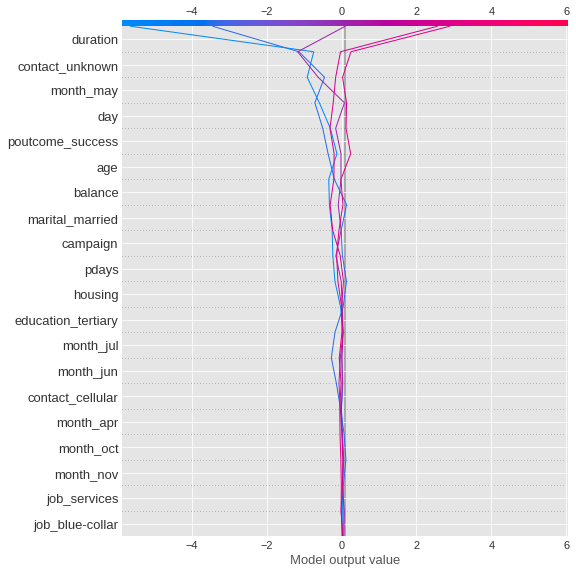

In [23]:
expected_value = explainer.expected_value
shap_array = explainer.shap_values(X_test)

shap.decision_plot(expected_value, shap_array[20:25],feature_names=list(X_test.columns))

In [24]:
pd.DataFrame(X_test)[20:25]

,age,default,balance,housing,loan,day,duration,campaign,pdays,previous,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
6768,48,0,0,0,0,18,96,3,-1,0,...,1,0,0,0,0,0,0,0,0,1
5931,27,0,97,1,1,18,13,3,-1,0,...,0,0,1,0,0,0,0,0,0,1
10027,30,0,699,1,0,29,544,1,-1,0,...,0,0,1,0,0,0,0,0,0,1
2003,26,0,26,1,1,15,899,1,-1,0,...,0,0,1,0,0,0,0,0,0,1
700,51,0,7098,0,0,6,1471,7,-1,0,...,0,0,0,0,0,0,0,0,0,1
